In [1]:
!pip install opencv-python

In [2]:
!pip install numpy

In [3]:
!pip install tensorflow

In [4]:
!pip install scikit-learn

In [5]:
!pip install imageio[ffmpeg]

In [6]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_dir = 'dataset_file'
high_violence_dir = os.path.join(data_dir, 'High-violence')
low_violence_dir = os.path.join(data_dir,'Low-violence')
non_violence_dir = os.path.join(data_dir, 'Non-violence')

max_frames = 100

In [7]:
high_violence_videos = [os.path.join(high_violence_dir, video) for video in os.listdir(high_violence_dir)]
low_violence_videos = [os.path.join(low_violence_dir, video) for video in os.listdir(low_violence_dir)]
non_violence_videos = [os.path.join(non_violence_dir, video) for video in os.listdir(non_violence_dir)]

In [8]:
import cv2
import numpy as np
import imageio

def load_and_preprocess_video(video_path, target_size=(64, 64), max_frames=100):
    try:
        # Open the video file using the imageio library
        video = imageio.get_reader(video_path, 'ffmpeg')
        
        # Initialize an empty list to store preprocessed frames
        frames = []

        # Iterate through frames in the video
        for i, frame in enumerate(video):
            # Break the loop if the maximum frame limit is reached
            if i >= max_frames:
                break
            
            # Resize the frame to the specified target size
            frame = cv2.resize(frame, target_size)
            
            # Normalize pixel values to the range [0, 1]
            frame = frame / 255.0
            
            # Append the preprocessed frame to the frames list
            frames.append(frame)

        # Close the video file
        video.close()

        # If the number of frames is less than the maximum, pad with zeros
        if len(frames) < max_frames:
            frames += [np.zeros_like(frames[0])] * (max_frames - len(frames))
        # If there are more frames than the maximum, truncate the list
        elif len(frames) > max_frames:
            frames = frames[:max_frames]

        # Convert the list of frames to a numpy array and stack them along a new axis
        return np.stack(frames)
    
    except Exception as e:
        # Print an error message if video processing fails
        print(f"Error processing video '{video_path}': {str(e)}")
        
        # Return None to indicate failure
        return None


In [9]:
from sklearn.model_selection import train_test_split

In [10]:
# Initialize empty lists to store video frames
X = []
y = []

# Concatenate video paths and create labels based on violence levels
video_paths = high_violence_videos + low_violence_videos + non_violence_videos
labels = [2] * len(high_violence_videos) + [1] * len(low_violence_videos) + [0] * len(non_violence_videos)

# Iterate through video paths and labels simultaneously
for video_path, label in zip(video_paths, labels):
    # Load and preprocess video frames using the defined function
    frames = load_and_preprocess_video(video_path)
    
    # Check if video processing was successful
    if frames is not None:
        X.append(frames)
        y.append(label)

# Convert the lists of frames (X) and labels (y) to numpy arrays
X = np.array(X)
y = np.array(y)


In [11]:
# Calculate the total number of frames in the dataset
total_frames = len(X) * 100

# Calculate the remainder when dividing total_frames by 100
remainder = total_frames % 100

# Duplicate frames to complete the last batch
X = np.concatenate([X, X[:remainder]])

# Reshape X to a 5D tensor assuming 100 frames per video
X = X.reshape((-1, max_frames, 64, 64, 3))

print("Number of samples after reshaping:", X.shape[0], y.shape[0])

# Split the data into training and validation sets using a 80-20 split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training and validation sets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)


Number of samples after reshaping: 166 166
X_train shape: (132, 100, 64, 64, 3)
y_train shape: (132,)
X_val shape: (34, 100, 64, 64, 3)
y_val shape: (34,)


In [12]:
# Create a Sequential model
model = Sequential()

# Add a 3D convolutional layer with 32 filters, kernel size (3, 3, 3), and ReLU activation
model.add(Conv3D(32, kernel_size=(3, 3, 3), input_shape=(max_frames, 64, 64, 3), activation='relu'))

# Add a 3D max pooling layer with pool size (2, 2, 2)
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Add another 3D convolutional layer with 64 filters, kernel size (3, 3, 3), and ReLU activation
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))

# Add another 3D max pooling layer with pool size (2, 2, 2)
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Flatten the output from the convolutional layers
model.add(Flatten())

# Add a dense layer with 128 units and ReLU activation
model.add(Dense(128, activation='relu'))

# Add batch normalization to improve training stability
model.add(BatchNormalization())

# Add the output layer with 3 units (adjust based on the number of classes) and softmax activation
model.add(Dense(3, activation='softmax'))

# Compile the model using the Adam optimizer, sparse categorical crossentropy loss, and accuracy metric
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Train the model on the prepared dataset with 10 epochs and validation data
model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))




Epoch 1/10


5/5 [==============================] - 16s 2s/step - loss: 1.4866 - accuracy: 0.3864 - val_loss: 29.8954 - val_accuracy: 0.4412
Epoch 2/10
5/5 [==============================] - 7s 1s/step - loss: 0.9466 - accuracy: 0.5833 - val_loss: 13.8103 - val_accuracy: 0.4412
Epoch 3/10
5/5 [==============================] - 7s 1s/step - loss: 0.7188 - accuracy: 0.6591 - val_loss: 5.9265 - val_accuracy: 0.3235
Epoch 4/10
5/5 [==============================] - 7s 1s/step - loss: 0.5357 - accuracy: 0.7803 - val_loss: 2.4187 - val_accuracy: 0.3824
Epoch 5/10
5/5 [==============================] - 7s 1s/step - loss: 0.4463 - accuracy: 0.8409 - val_loss: 4.4701 - val_accuracy: 0.2353
Epoch 6/10
5/5 [==============================] - 7s 1s/step - loss: 0.3511 - accuracy: 0.8788 - val_loss: 4.1238 - val_accuracy: 0.2353
Epoch 7/10
5/5 [==============================] - 7s 1s/step - loss: 0.2461 - accuracy: 0.9394 - val_loss: 3.3882 - val_accuracy: 0.2059
Epoch 8/10
5/5 [==================

In [13]:
model.save('violence_detection_model.h5')

C:\Users\abisa\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
# Assuming you have a validation set (X_val, y_val)
eval_results = model.evaluate(X_val, y_val)
print("Validation Loss:", eval_results[0])
print("Validation Accuracy:", eval_results[1])

2/2 [==============================] - 1s 35ms/step - loss: 1.4098 - accuracy: 0.4706
Validation Loss: 1.4098063707351685
Validation Accuracy: 0.47058823704719543


Epoch 1/10
5/5 [==============================] - 7s 1s/step - loss: 0.0856 - accuracy: 0.9848 - val_loss: 1.4395 - val_accuracy: 0.5000
Epoch 2/10
5/5 [==============================] - 7s 1s/step - loss: 0.1007 - accuracy: 0.9773 - val_loss: 2.2367 - val_accuracy: 0.5000
Epoch 3/10
5/5 [==============================] - 7s 1s/step - loss: 0.0709 - accuracy: 0.9924 - val_loss: 2.5442 - val_accuracy: 0.4706
Epoch 4/10
5/5 [==============================] - 7s 1s/step - loss: 0.0870 - accuracy: 0.9924 - val_loss: 2.7832 - val_accuracy: 0.4706
Epoch 5/10
5/5 [==============================] - 7s 1s/step - loss: 0.1065 - accuracy: 0.9773 - val_loss: 2.1518 - val_accuracy: 0.5000
Epoch 6/10
5/5 [==============================] - 7s 1s/step - loss: 0.1033 - accuracy: 0.9773 - val_loss: 1.9851 - val_accuracy: 0.3824
Epoch 7/10
5/5 [==============================] - 7s 1s/step - loss: 0.0959 - accuracy: 0.9697 - val_loss: 2.1601 - val_accuracy: 0.3824
Epoch 8/10
5/5 [=========================

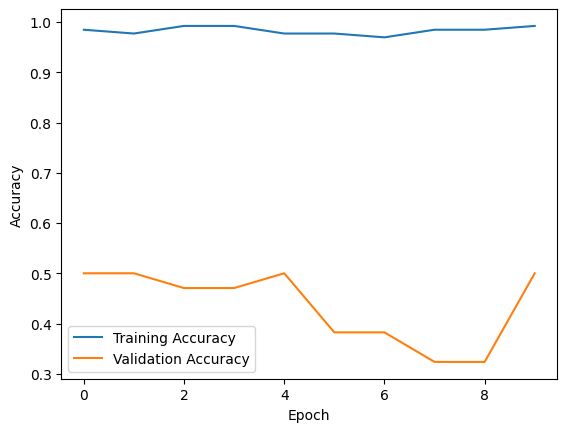

In [15]:
# Generate and display charts or visualizations
# Example: Training and Validation Accuracy/Loss Plots
import matplotlib.pyplot as plt

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

2/2 [==============================] - 1s 33ms/step


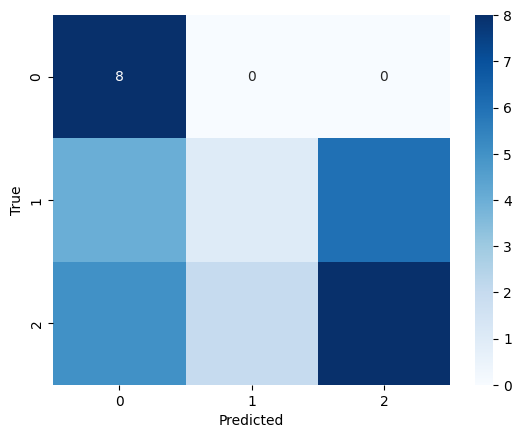

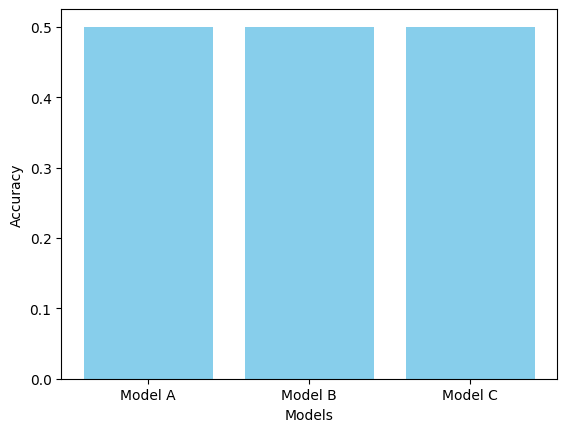

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Example: Confusion Matrix
y_pred_prob = model.predict(X_val)
y_pred = np.argmax(y_pred_prob, axis=1)

conf_mat = confusion_matrix(y_val, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

from sklearn.metrics import accuracy_score

# Calculate accuracy from the confusion matrix
accuracy_model_a = accuracy_score(y_val, y_pred)  # Replace y_pred with predictions for Model A
accuracy_model_b = accuracy_score(y_val, y_pred)  # Replace y_pred with predictions for Model B
accuracy_model_c = accuracy_score(y_val, y_pred)  # Replace y_pred with predictions for Model C

models = ['Model A', 'Model B', 'Model C']
accuracies = [accuracy_model_a, accuracy_model_b, accuracy_model_c]

plt.bar(models, accuracies, color='skyblue')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.show()

In [17]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('violence_detection_model.h5')

# Define the classes
classes = ['Non-violence', 'Low-violence', 'High-violence']

# Start capturing video from the camera
cap = cv2.VideoCapture(0)  # Use 0 for default camera, adjust as needed

# Get the native resolution of the camera
original_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
original_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Set the window size to the native resolution
cv2.namedWindow('Violence Detection', cv2.WINDOW_NORMAL)
cv2.resizeWindow('Violence Detection', original_width, original_height)

# Initialize a buffer to store frames
frame_buffer = []

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Check if the frame is valid
    if not ret:
        print("Error: Could not read frame. Exiting...")
        break

    # Preprocess the frame
    frame_resized = cv2.resize(frame, (64, 64))
    frame_normalized = frame_resized / 255.0

    # Add the frame to the buffer
    frame_buffer.append(frame_normalized)

    # Maintain a buffer of 100 frames
    if len(frame_buffer) == 100:
        # Convert the buffer to a numpy array and add batch dimension
        frame_sequence = np.expand_dims(np.array(frame_buffer), axis=0)

        # Make predictions
        predictions = model.predict(frame_sequence)
        class_index = np.argmax(predictions)
        confidence = predictions[0, class_index]

        # Get the class label
        class_label = classes[class_index]

        # Display additional information on the frame
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 1.0  # Adjust the font scale as needed
        font_thickness = 2  # Adjust the font thickness as needed

        # Display class label and confidence
        cv2.putText(frame, f'Class: {class_label} ({confidence:.2f})', (10, 30),
                    font, font_scale, (0, 255, 0), font_thickness, cv2.LINE_AA)

        # Display current webcam resolution
        cv2.putText(frame, f'Resolution: {original_width}x{original_height}', (10, 60),
                    font, font_scale, (255, 255, 255), font_thickness, cv2.LINE_AA)

        # Display other elements or information as needed

        # Display the frame
        cv2.imshow('Violence Detection', frame)

        # Clear the frame buffer for the next sequence
        frame_buffer = []

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    # Adjust the delay time (in milliseconds) to speed up or slow down the video streaming
    cv2.waitKey(5)

# Release the camera and close all windows
cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 41ms/step


KeyboardInterrupt: 